https://forecastegy.com/posts/multi-step-time-series-forecasting-in-python/

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from sklearn.ensemble import RandomForestRegressor

In [2]:

class ETL:
    """
    ticker: str
    period: string
    test_size: float betwee 0 and 1
    n_input: int
    timestep: int
    Extracts data for stock with ticker `ticker` from yf api,
    splits the data into train and test sets by date,
    reshapes the data into np.array of shape [#weeks, 5, 1],
    converts our problem into supervised learning problem.
    """

    def __init__(self, datainput, test_size=0.2, n_input=5, timestep=5, normalize_bool=False, scaler=None, target_col=None) -> None:
        self.datainput = datainput
        self.test_size = test_size
        self.n_input = n_input
        self.timestep = timestep
        self.normalize_bool = normalize_bool
        self.scaler = scaler
        self.target_col = target_col
        self.df = self.extract_historic_data()
        self.train, self.test = self.etl()
        self.X_train, self.y_train = self.to_supervised(self.train)
        self.X_test, self.y_test = self.to_supervised(self.test)

        if self.normalize_bool:
            print('normalized', normalize_bool)
            self.scaler = scaler
        else:
            print('not normalized', normalize_bool)
            self.scaler = None

    def extract_historic_data(self) -> pd.DataFrame:
        if self.normalize_bool:
            data = self.scaler.fit_transform(self.datainput)
            return pd.DataFrame(data, columns=self.datainput.columns)
        else:
            return self.datainput

    def split_data(self) -> tuple:
        """
        Splits our pd.Series into train and test series with
        test series representing test_size * 100 % of data.
        """
        # data = self.extract_historic_data()
        data = self.df
        if len(data) != 0:
            train_idx = round(len(data) * (1 - self.test_size))
            train = data.iloc[:train_idx]
            test = data.iloc[train_idx:]
            return train, test
        else:
            raise Exception('Data set is empty, cannot split.')

    def window_and_reshape(self, data) -> np.array:
        """
        Reformats data into shape our model needs.
        """
        samples = data.shape[0] // self.timestep
        if samples <= 0:
            raise ValueError(
                "The number of samples is less than or equal to 0. Ensure data length is greater than timestep.")
        result = np.array_split(data[:samples * self.timestep], samples)
        return np.array(result)

    def transform(self, train, test) -> np.array:
        train_remainder = train.shape[0] % self.timestep
        test_remainder = test.shape[0] % self.timestep
        if train_remainder != 0:
            train = train[:-(train_remainder)]
        if test_remainder != 0:
            test = test[:-(test_remainder)]
        # print("train:", train, "test:", test)
        if len(train) < self.timestep or len(test) < self.timestep:
            raise ValueError(
                "Not enough data to form at least one timestep window.")
        train_transformed, test_transformed = self.window_and_reshape(
            train), self.window_and_reshape(test)
        print(f'train_transformed shape: {train_transformed.shape}')
        print(f'test_transformed shape: {test_transformed.shape}')
        return train_transformed, test_transformed

    def etl(self) -> tuple[np.array, np.array]:
        """
        Runs complete ETL
        """
        train, test = self.split_data()
        print("train:", train, "test:", test)
        return self.transform(train, test)

    def to_supervised(self, data, n_out=5) -> tuple:
        X, y = [], []
        for sample in data:
            if len(sample) >= self.n_input + n_out:
                for i in range(len(sample) - self.n_input - n_out + 1):
                    X.append(sample[i:i + self.n_input])
                    y.append(sample[i + self.n_input:i +
                             self.n_input + n_out, :])
        print(len(sample) - self.n_input - n_out + 1)
        X, y = np.array(X), np.array(y)
        print(f'X shape: {X.shape}')
        print(f'y shape: {y.shape}')
        return X, y

In [3]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.2, epsilon=1e-6, attention_axes=None, kernel_size=1):
    x = layers.LayerNormalization(epsilon=epsilon)(inputs)
    attention_output, _ = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout,
        attention_axes=attention_axes
    )(x, x, return_attention_scores=True)
    x = layers.Dropout(dropout)(attention_output)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=epsilon)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=kernel_size,
                      activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=kernel_size)(x)
    return x + res


def build_transformer(head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout=0.2, mlp_dropout=0.2, attention_axes=None, epsilon=1e-6, kernel_size=1):
    n_timesteps, n_features, n_outputs = 5, 3, 15
    inputs = tf.keras.Input(shape=(n_timesteps, n_features))
    masked_inputs = layers.Masking()(inputs)
    # x = inputs
    x = masked_inputs
    for _ in range(num_trans_blocks):
        x = transformer_encoder(x, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim,
                                dropout=dropout, attention_axes=attention_axes, kernel_size=kernel_size, epsilon=epsilon)
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_outputs)(x)
    outputs = layers.Reshape((n_timesteps, n_features))(outputs)
    return tf.keras.Model(inputs, outputs)


def build_custom_transformer(head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout=0.2, mlp_dropout=0.2, attention_axes=None, epsilon=1e-6, kernel_size=1):
    n_timesteps, n_features, n_outputs = 5, 3, 15  
    inputs = tf.keras.Input(shape=(n_timesteps, n_features))

    # Split inputs for each feature
    inputs_split = [inputs[:, :, i:i+1] for i in range(n_features)]

    # Create separate transformer encoders for each feature
    encoded_features = []
    for input_feature in inputs_split:
        x = input_feature
        for _ in range(num_trans_blocks):
            x = transformer_encoder(x, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim,
                                    dropout=dropout, attention_axes=attention_axes, kernel_size=kernel_size, epsilon=epsilon)
        encoded_features.append(x)

    # Concatenate the encoded features
    concatenated = layers.Concatenate(axis=-1)(encoded_features)
    x = layers.GlobalAveragePooling1D(
        data_format="channels_first")(concatenated)

    # Fully connected layers
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_outputs)(x)

    return tf.keras.Model(inputs, outputs)


def fit_transformer(transformer, x_train, y_train, x_val, y_val, display_loss=False):
    transformer.compile(
        loss="mse",
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        metrics=["mae", 'mape']
    )

    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True)]

    hist = transformer.fit(x_train, y_train,
                           validation_data=(x_val, y_val),
                           batch_size=32, epochs=25,
                           verbose=1, callbacks=callbacks)

    if display_loss:
        history_df = pd.DataFrame(hist.history)
        history_df['val_loss'].plot()
        plt.title('Validation Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Validation'], loc='upper right')
        plt.show()
        history_df['loss'].plot()
        plt.title('Training Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train'], loc='upper right')
        plt.show()

        history_df.loc[:, ['mae', 'val_mae']].plot()
        plt.title('Model MAE')
        plt.ylabel('MAE')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.show()

    return hist

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


class PredictAndForecast:
    def __init__(self, model, train, test, n_input=30, scaler=None, normalize_bool=False) -> None:
        self.model = model
        self.train = train
        self.test = test
        self.n_input = n_input
        self.scaler = scaler
        self.normalize_bool = normalize_bool
        # self.predictions = self.get_predictions()

    def forecast(self, history) -> np.array:
        """
        Given last weeks actual data, forecasts next weeks prices.
        """
        # flatten data
        data = np.array(history)
        data = data.reshape((data.shape[0] * data.shape[1], data.shape[2]))

        # retrieve last observations for input data
        input_x = data[-self.n_input:, :]

        input_x = input_x.reshape((1, self.n_input, input_x.shape[1]))

        # forecast the next week
        yhat = self.model.predict(input_x, verbose=0)

        # we only want the vector forecast
        yhat = yhat[0]
        return yhat

    def get_predictions(self, step) -> np.array:
        """
        Compiles models predictions week by week over entire
        test set.
        """
        # history is a list of weekly data
        history = [x for x in self.train]

        # walk-forward validation over each week
        predictions = []
        for i in range(len(self.test)):
            yhat_sequence = self.forecast(history)
            predictions.append(yhat_sequence)
            history.append(self.test[i, :])
        if step > len(self.test):
            for _ in range(step - len(self.test)):
                yhat_sequence = self.forecast(history)
                predictions.append(yhat_sequence)
                history.append(yhat_sequence)

        predictions = np.array(predictions)
        print(f"Predictions shape: {predictions.shape}")
        return predictions

    def recursive_predict(self, steps: int) -> pd.Series:
        print("************************")
        train_series = pd.Series(self.train.flatten())
        test_series = pd.Series(self.test.flatten())
        print(f"Initial training series:\n{train_series}\n")
        print(f"train value {train_series}")
        print(f"origin value {test_series}")
        print("***********************")
        forecaster = ForecasterAutoreg(
            regressor=LinearRegression(), lags=self.n_input)

        predictions = []
        history = train_series.copy()
        # history = list(train_series)
        forecaster.fit(y=train_series)

        for step in range(steps):
            # forecaster.fit(y=pd.Series(history))
            next_prediction = forecaster.predict(steps=1)
            predicted_value = next_prediction.values[0]
            original_value = test_series[step] if step < len(
                test_series) else None

            print(f"Step {step + 1}:")
            print(f"Predicted value: {predicted_value}")
            print(f"Original value: {original_value}")
            print(f"next prediction:{next_prediction}")

            if original_value is not None:
                if original_value == 0:
                    predictions.append(predicted_value)
                    print(f"Prediction reality.{predicted_value}")
                elif abs(predicted_value - original_value) <= 0.05:
                    predictions.append(predicted_value)
                    print("Prediction within tolerance.")
                else:
                    adjusted_prediction = (
                        predicted_value + original_value) / 2
                    predictions.append(adjusted_prediction)
                    print(f"Adjusted prediction: {adjusted_prediction}")
            else:
                predictions.append(predicted_value)
                print("No original value to compare. Using predicted value.")
            history = pd.concat(
                [history, pd.Series([predicted_value], index=[history.index[-1] + 1])])

            # Refit the model with the updated history
            forecaster.fit(y=history)

            # history = pd.concat(
            #     [history, pd.Series([predicted_value], index=[history.index[-1] + 1])])

        prediction_series = pd.Series(predictions, index=pd.date_range(
            start=history.index[-steps], periods=steps, freq='D'))
        # prediction_dates = pd.date_range(
        #     start=len(test_series), periods=steps, freq='D')
        # prediction_series = pd.Series(predictions, index=prediction_dates)

        print(f"Final prediction series:\n{prediction_series}\n")
        return prediction_series

    def direct_predict(self, steps: int) -> pd.Series:
        # train_series = pd.Series(self.train.flatten(), index=pd.date_range(
        #     start='2000', periods=len(self.train.flatten())))
        train_series = pd.Series(self.train.flatten())
        test_series = pd.Series(self.test.flatten())

        max_steps = min(steps, len(train_series) - self.n_input)

        forecaster = ForecasterAutoregDirect(
            regressor=LinearRegression(), lags=self.n_input, steps=max_steps)
        forecaster.fit(y=train_series)
        predictions = forecaster.predict()
        prediction_series = pd.Series(predictions.values, index=pd.date_range(
            start=train_series.index[-1], periods=max_steps + 1, freq='D')[1:])
        return prediction_series

    def plot_predictions(self, steps: int, preds, normaliza_bool, scaler) -> None:
        recursive_prediction_series = self.recursive_predict(steps)
        direct_prediction_series = self.direct_predict(steps)

        # Ensure both predictions have the same length
        min_steps = min(len(recursive_prediction_series),
                        len(direct_prediction_series))
        recursive_prediction_series = recursive_prediction_series[:min_steps]
        direct_prediction_series = direct_prediction_series[:min_steps]

        plot_preds = preds[:min_steps]
        # Flatten self.train for plotting
        train_series = self.train.reshape(-1, 3)
        test_series = self.test.reshape(-1, 3)

        if normaliza_bool:
            reshaped_recursive = np.repeat(
                recursive_prediction_series.values.reshape(-1, 1), 3, axis=1)
            reshaped_direct = np.repeat(
                direct_prediction_series.values.reshape(-1, 1), 3, axis=1)
            reshaped_preds = np.repeat(plot_preds.reshape(-1, 1), 3, axis=1)

            inverse_recursive = scaler.inverse_transform(reshaped_recursive)[
                :, 0]
            inverse_direct = scaler.inverse_transform(reshaped_direct)[:, 0]
            inverse_preds = scaler.inverse_transform(reshaped_preds)[:, 0]

            recursive_prediction_series = pd.Series(
                inverse_recursive, index=recursive_prediction_series.index)
            direct_prediction_series = pd.Series(
                inverse_direct, index=direct_prediction_series.index)
            plot_preds = inverse_preds

            train_series = scaler.inverse_transform(train_series).flatten()
            test_series = scaler.inverse_transform(test_series).flatten()

        plt.figure(figsize=(10, 6))
        # Plot the training data
        plt.plot(range(len(train_series)), train_series, label='Training Data')

        # Plot the test data
        test_start_index = len(train_series)
        plt.plot(range(test_start_index, test_start_index +
                 len(test_series)), test_series, label='Origin Data', color='black')

        # Adjust prediction indices to align with the start of the test data
        prediction_start_index = test_start_index
        plt.plot(range(prediction_start_index, prediction_start_index + min_steps), plot_preds,
                 label='Hybrid Predictions', linestyle='--', color='green')
        plt.plot(range(prediction_start_index, prediction_start_index + min_steps), recursive_prediction_series,
                 label='Recursive Predictions', color='red')
        plt.plot(range(prediction_start_index, prediction_start_index + min_steps), direct_prediction_series,
                 label='Direct Predictions', color='purple')

        plt.xlabel('Time Steps')
        plt.ylabel('Values')
        plt.title('Recursive vs Direct Predictions')
        plt.legend()
        plt.show()
        return test_series[:min_steps], recursive_prediction_series, direct_prediction_series, plot_preds

    def evaluate_predictions(self, test_series, recursive_preds, direct_preds, hybrid_preds):
        metrics = {
            'recursive': {
                'MAE': mean_absolute_error(test_series, recursive_preds),
                'MAPE': mean_absolute_percentage_error(test_series, recursive_preds),
                'RMSE': np.sqrt(mean_squared_error(test_series, recursive_preds)),
                'R2': r2_score(test_series, recursive_preds)
            },
            'direct': {
                'MAE': mean_absolute_error(test_series, direct_preds),
                'MAPE': mean_absolute_percentage_error(test_series, direct_preds),
                'RMSE': np.sqrt(mean_squared_error(test_series, direct_preds)),
                'R2': r2_score(test_series, direct_preds)
            },
            'hybrid': {
                'MAE': mean_absolute_error(test_series, hybrid_preds),
                'MAPE': mean_absolute_percentage_error(test_series, hybrid_preds),
                'RMSE': np.sqrt(mean_squared_error(test_series, hybrid_preds)),
                'R2': r2_score(test_series, hybrid_preds)
            }
        }
        print("Evaluation Metrics:")
        print("\nRecursive Predictions:")
        print(f"MAE: {metrics['recursive']['MAE']}")
        print(f"MAPE: {metrics['recursive']['MAPE']}")
        print(f"RMSE: {metrics['recursive']['RMSE']}")
        print(f"R2: {metrics['recursive']['R2']}")

        print("\nDirect Predictions:")
        print(f"MAE: {metrics['direct']['MAE']}")
        print(f"MAPE: {metrics['direct']['MAPE']}")
        print(f"RMSE: {metrics['direct']['RMSE']}")
        print(f"R2: {metrics['direct']['R2']}")

        print("\nHybrid Predictions:")
        print(f"MAE: {metrics['hybrid']['MAE']}")
        print(f"MAPE: {metrics['hybrid']['MAPE']}")
        print(f"RMSE: {metrics['hybrid']['RMSE']}")
        print(f"R2: {metrics['hybrid']['R2']}")
        return metrics

In [5]:
def calculate_TEMA(data, period=10):
    ema1 = data.ewm(span=period, adjust=False).mean()
    ema2 = ema1.ewm(span=period, adjust=False).mean()
    ema3 = ema2.ewm(span=period, adjust=False).mean()
    tema = (3 * ema1) - (3 * ema2) + ema3
    return tema.dropna()


def calculate_DEMA(data, period=10):
    ema1 = data.ewm(span=period, adjust=False).mean()
    ema2 = ema1.ewm(span=period, adjust=False).mean()
    dema = 2 * ema1 - ema2
    return dema


ticker = '^GSPC'
dataset = yf.download(ticker, start='1990-01-01',
                      end=datetime.now().strftime('%Y-%m-%d'), interval='1d')
dataset = dataset[['Close']]

data1 = calculate_DEMA(dataset['Close'], 10)
data2 = calculate_TEMA(dataset['Close'], 10)


dataset_input = pd.DataFrame({
    'Close': dataset['Close'],
    'DEMA': data1,
    'TEMA': data2
})
print(dataset_input)

[*********************100%%**********************]  1 of 1 completed

                  Close         DEMA         TEMA
Date                                             
1990-01-02   359.690002   359.690002   359.690002
1990-01-03   358.760010   359.382567   359.269375
1990-01-04   355.670013   358.134696   357.593960
1990-01-05   352.200012   356.070760   354.924567
1990-01-08   353.790009   355.086776   353.913206
...                 ...          ...          ...
2024-08-01  5446.680176  5456.648572  5444.475293
2024-08-02  5346.560059  5416.142546  5393.531229
2024-08-05  5186.330078  5333.758106  5288.452841
2024-08-06  5240.029785  5291.486507  5245.062796
2024-08-07  5199.500000  5248.089665  5201.272144

[8716 rows x 3 columns]


In [6]:
scaler_type = StandardScaler()
# Prepare the ETL instance
data = ETL(
    datainput=dataset_input,
    test_size=0.1,
    n_input=5,  # Look-back period
    timestep=10,  # Number of past days to use for each prediction
    normalize_bool=True,
    scaler=scaler_type
)

X_train, y_train = data.X_train, data.y_train
X_val, y_val = data.X_test, data.y_test
print(f"X_train shape: {data.X_train.shape}")
print(f"X_test shape: {data.X_test.shape}")
print(f"y_train shape: {data.y_train.shape}")
print(f"y_test shape: {data.y_test.shape}")

train:          Close      DEMA      TEMA
0    -1.091944 -1.091725 -1.091823
1    -1.092733 -1.091986 -1.092180
2    -1.095356 -1.093045 -1.093602
3    -1.098301 -1.094796 -1.095867
4    -1.096951 -1.095631 -1.096725
...        ...       ...       ...
7839  1.926539  1.923138  1.934044
7840  1.942197  1.934103  1.944449
7841  1.940296  1.941066  1.949342
7842  1.939226  1.945332  1.950944
7843  1.924493  1.943099  1.944259

[7844 rows x 3 columns] test:          Close      DEMA      TEMA
7844  1.918332  1.938936  1.936090
7845  1.892693  1.926979  1.918367
7846  1.896827  1.919190  1.908029
7847  1.934219  1.925579  1.917969
7848  1.852670  1.903172  1.887715
...        ...       ...       ...
8711  3.225270  3.232912  3.222961
8712  3.140300  3.198543  3.179732
8713  3.004317  3.128642  3.090566
8714  3.049890  3.092776  3.053746
8715  3.015494  3.055955  3.016587

[872 rows x 3 columns]
train_transformed shape: (784, 10, 3)
test_transformed shape: (87, 10, 3)
1
X shape: (784, 5, 3)
y

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [7]:
data.train

array([[[-1.09194414, -1.09172535, -1.0918234 ],
        [-1.0927334 , -1.0919862 , -1.09218033],
        [-1.09535581, -1.09304499, -1.09360203],
        ...,
        [-1.10141538, -1.10036254, -1.10194082],
        [-1.10871402, -1.10349989, -1.10571718],
        [-1.11120063, -1.10658694, -1.1092178 ]],

       [[-1.10801809, -1.10774677, -1.10992641],
        [-1.11086117, -1.10946444, -1.11147948],
        [-1.11019071, -1.11043148, -1.11201408],
        ...,
        [-1.1204682 , -1.11853321, -1.11978311],
        [-1.12070583, -1.12009753, -1.12120829],
        [-1.12121502, -1.12132565, -1.12219181]],

       [[-1.12309908, -1.12275934, -1.12350723],
        [-1.11792217, -1.12201187, -1.12185757],
        [-1.11816827, -1.12145019, -1.12070461],
        ...,
        [-1.1146293 , -1.11674105, -1.11459051],
        [-1.11406917, -1.11592085, -1.1138021 ],
        [-1.11707349, -1.1162961 , -1.11468142]],

       ...,

       [[ 1.77009346,  1.76694648,  1.76648291],
        [ 1

Epoch 1/25


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy th

25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - loss: 0.6571 - mae: 0.6538 - mape: 169.9601 - val_loss: 3.2924 - val_mae: 1.7453 - val_mape: 74.6600
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2973 - mae: 0.4327 - mape: 144.6645 - val_loss: 2.0746 - val_mae: 1.3942 - val_mape: 59.6300
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1648 - mae: 0.3221 - mape: 97.3674 - val_loss: 0.8794 - val_mae: 0.8780 - val_mape: 37.4783
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1304 - mae: 0.2818 - mape: 150.9784 - val_loss: 0.2808 - val_mae: 0.4706 - val_mape: 20.0098
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0973 - mae: 0.2450 - mape: 103.1089 - val_loss: 0.3035 - val_mae: 0.5146 - val_mape: 22.0293
Epoch 6/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0970 - mae: 0.2442 - mape: 126.8990 - val_loss: 0.4048 - val_mae: 0.5865 - val_mape: 25.3340
Epoch 7/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1007 - mae: 0.2544 - mape:

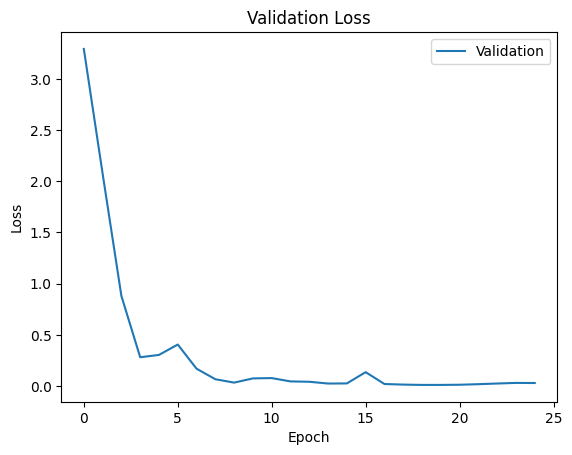

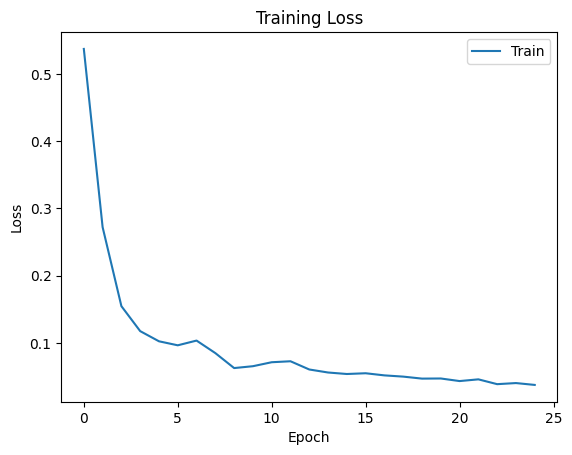

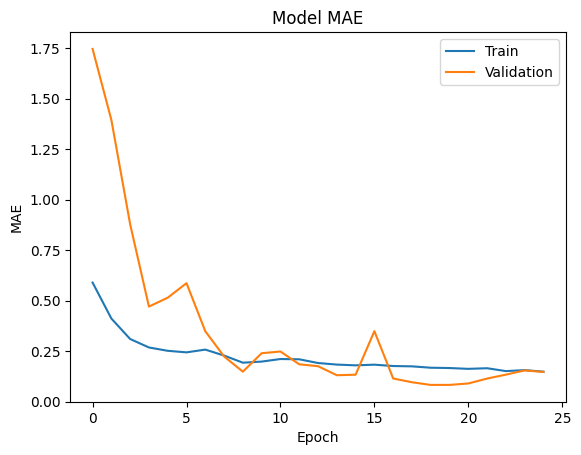

In [8]:
model = build_transformer(head_size=16, num_heads=4,
                          ff_dim=128, num_trans_blocks=12,
                          mlp_units=[64],
                          dropout=0.2, mlp_dropout=0.2)
# model = build_custom_transformer(head_size=16, num_heads=4,
#                           ff_dim=128, num_trans_blocks=12,
#                           mlp_units=[64],
#                           dropout=0.2, mlp_dropout=0.2)
fit_transformer(model, X_train, y_train, X_val, y_val, display_loss=True)

Predictions shape: (1700, 5, 3)
Predictions shape: (1700, 5, 3)
************************
Initial training series:
0       -1.091944
1       -1.091725
2       -1.091823
3       -1.092733
4       -1.091986
           ...   
11755    1.831893
11756    1.827899
11757    1.888654
11758    1.851067
11759    1.854586
Length: 11760, dtype: float64

train value 0       -1.091944
1       -1.091725
2       -1.091823
3       -1.092733
4       -1.091986
           ...   
11755    1.831893
11756    1.827899
11757    1.888654
11758    1.851067
11759    1.854586
Length: 11760, dtype: float64
origin value 0       1.918332
1       1.938936
2       1.936090
3       1.892693
4       1.926979
          ...   
1300    3.243575
1301    3.211303
1302    3.239579
1303    3.237523
1304    3.211411
Length: 1305, dtype: float64
***********************
Step 1:
Predicted value: 1.8747011485255058
Original value: 1.9183318907921563
next prediction:11760    1.874701
Name: pred, dtype: float64
Prediction within tolera

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12

Step 32:
Predicted value: 1.8886029568303053
Original value: 1.9473907738871008
next prediction:5    1.888603
Name: pred, dtype: float64
Adjusted prediction: 1.917996865358703
Step 33:
Predicted value: 1.889423008227257
Original value: 1.9508162146567054
next prediction:5    1.889423
Name: pred, dtype: float64
Adjusted prediction: 1.9201196114419812
Step 34:
Predicted value: 1.8902434377689687
Original value: 1.9470851922343924
next prediction:5    1.890243
Name: pred, dtype: float64
Adjusted prediction: 1.9186643150016804
Step 35:
Predicted value: 1.8910650834695952
Original value: 1.9498057063346157
next prediction:5    1.891065
Name: pred, dtype: float64
Adjusted prediction: 1.9204353949021056
Step 36:
Predicted value: 1.8918859965646613
Original value: 1.952064395187432
next prediction:5    1.891886
Name: pred, dtype: float64
Adjusted prediction: 1.9219751958760467
Step 37:
Predicted value: 1.8927074124460042
Original value: 1.9215654017943509
next prediction:5    1.892707
Name: pr

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/pyt

Step 59:
Predicted value: 1.910834778535663
Original value: 2.086372105170736
next prediction:5    1.910835
Name: pred, dtype: float64
Adjusted prediction: 1.9986034418531995
Step 60:
Predicted value: 1.9116612555740955
Original value: 2.1034319018928063
next prediction:5    1.911661
Name: pred, dtype: float64
Adjusted prediction: 2.007546578733451
Step 61:
Predicted value: 1.9124879514251933
Original value: 2.1360599376596454
next prediction:5    1.912488
Name: pred, dtype: float64
Adjusted prediction: 2.0242739445424194
Step 62:
Predicted value: 1.9133148658268566
Original value: 2.151387862677523
next prediction:5    1.913315
Name: pred, dtype: float64
Adjusted prediction: 2.0323513642521895
Step 63:
Predicted value: 1.9141419992939133
Original value: 2.155031747216516
next prediction:5    1.914142
Name: pred, dtype: float64
Adjusted prediction: 2.034586873255215
Step 64:
Predicted value: 1.9149693516609272
Original value: 2.112025540041258
next prediction:5    1.914969
Name: pred, 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12

Step 95:
Predicted value: 1.9407261793473005
Original value: 2.1176128516675625
next prediction:5    1.940726
Name: pred, dtype: float64
Adjusted prediction: 2.0291695155074314
Step 96:
Predicted value: 1.9415605680695824
Original value: 2.107998524832096
next prediction:5    1.941561
Name: pred, dtype: float64
Adjusted prediction: 2.024779546450839
Step 97:
Predicted value: 1.942395177640436
Original value: 2.0956802103000607
next prediction:5    1.942395
Name: pred, dtype: float64
Adjusted prediction: 2.0190376939702483
Step 98:
Predicted value: 1.9432300081183058
Original value: 2.1089863244227316
next prediction:5    1.94323
Name: pred, dtype: float64
Adjusted prediction: 2.026108166270519
Step 99:
Predicted value: 1.9440650595616764
Original value: 2.098646965772385
next prediction:5    1.944065
Name: pred, dtype: float64
Adjusted prediction: 2.021356012667031
Step 100:
Predicted value: 1.9449003320290221
Original value: 2.1325467111728322
next prediction:5    1.9449
Name: pred, d

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12

Step 130:
Predicted value: 1.9700615729238162
Original value: 2.1387675835507562
next prediction:5    1.970062
Name: pred, dtype: float64
Adjusted prediction: 2.054414578237286
Step 131:
Predicted value: 1.970903726228116
Original value: 2.1813894482454557
next prediction:5    1.970904
Name: pred, dtype: float64
Adjusted prediction: 2.076146587236786
Step 132:
Predicted value: 1.9717461024361338
Original value: 2.170672348129379
next prediction:5    1.971746
Name: pred, dtype: float64
Adjusted prediction: 2.0712092252827565
Step 133:
Predicted value: 1.9725887016068668
Original value: 2.1882792962948545
next prediction:5    1.972589
Name: pred, dtype: float64
Adjusted prediction: 2.080433998950861
Step 134:
Predicted value: 1.973431523799344
Original value: 2.183561159259063
next prediction:5    1.973432
Name: pred, dtype: float64
Adjusted prediction: 2.0784963415292035
Step 135:
Predicted value: 1.9742745690725767
Original value: 2.175595465596015
next prediction:5    1.974275
Name: p

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12

Step 157:
Predicted value: 1.9928781241920759
Original value: 2.275158511424175
next prediction:5    1.992878
Name: pred, dtype: float64
Adjusted prediction: 2.1340183178081253
Step 158:
Predicted value: 1.9937263166512034
Original value: 2.3082481048636057
next prediction:5    1.993726
Name: pred, dtype: float64
Adjusted prediction: 2.1509872107574046
Step 159:
Predicted value: 1.9945747336125024
Original value: 2.3013329863194807
next prediction:5    1.994575
Name: pred, dtype: float64
Adjusted prediction: 2.1479538599659915
Step 160:
Predicted value: 1.9954233751354156
Original value: 2.216879893802154
next prediction:5    1.995423
Name: pred, dtype: float64
Adjusted prediction: 2.1061516344687847
Step 161:
Predicted value: 1.996272241279366
Original value: 2.280621239476407
next prediction:5    1.996272
Name: pred, dtype: float64
Adjusted prediction: 2.1384467403778866
Step 162:
Predicted value: 1.9971213321038173
Original value: 2.263315715132028
next prediction:5    1.997121
Name

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12

Step 195:
Predicted value: 2.025267765120114
Original value: 2.393323235996561
next prediction:5    2.025268
Name: pred, dtype: float64
Adjusted prediction: 2.2092955005583375
Step 196:
Predicted value: 2.026124530568811
Original value: 2.418610286915995
next prediction:5    2.026125
Name: pred, dtype: float64
Adjusted prediction: 2.222367408742403
Step 197:
Predicted value: 2.0269815227888266
Original value: 2.4028054063358724
next prediction:5    2.026982
Name: pred, dtype: float64
Adjusted prediction: 2.2148934645623495
Step 198:
Predicted value: 2.0278387418401627
Original value: 2.406451858119672
next prediction:5    2.027839
Name: pred, dtype: float64
Adjusted prediction: 2.2171452999799173
Step 199:
Predicted value: 2.0286961877828737
Original value: 2.3963834729182114
next prediction:5    2.028696
Name: pred, dtype: float64
Adjusted prediction: 2.2125398303505426
Step 200:
Predicted value: 2.029553860677008
Original value: 2.403042206850115
next prediction:5    2.029554
Name: p

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/pyt

Step 226:
Predicted value: 2.0519332129902104
Original value: 2.378544255292494
next prediction:5    2.051933
Name: pred, dtype: float64
Adjusted prediction: 2.2152387341413524
Step 227:
Predicted value: 2.052797036331507
Original value: 2.3403809246106047
next prediction:5    2.052797
Name: pred, dtype: float64
Adjusted prediction: 2.1965889804710557
Step 228:
Predicted value: 2.0536610883122073
Original value: 2.3322997510053747
next prediction:5    2.053661
Name: pred, dtype: float64
Adjusted prediction: 2.1929804196587908
Step 229:
Predicted value: 2.05452536899284
Original value: 2.3840606590424893
next prediction:5    2.054525
Name: pred, dtype: float64
Adjusted prediction: 2.2192930140176648
Step 230:
Predicted value: 2.0553898784339384
Original value: 2.3512823340880327
next prediction:5    2.05539
Name: pred, dtype: float64
Adjusted prediction: 2.2033361062609855
Step 231:
Predicted value: 2.0562546166960467
Original value: 2.3505713437488294
next prediction:5    2.056255
Name

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/pyt

Step 264:
Predicted value: 2.084919745172593
Original value: 2.489469854060038
next prediction:5    2.08492
Name: pred, dtype: float64
Adjusted prediction: 2.2871947996163158
Step 265:
Predicted value: 2.085792299490473
Original value: 2.4853164212945997
next prediction:5    2.085792
Name: pred, dtype: float64
Adjusted prediction: 2.2855543603925366
Step 266:
Predicted value: 2.0866650847587054
Original value: 2.4800169611299276
next prediction:5    2.086665
Name: pred, dtype: float64
Adjusted prediction: 2.2833410229443167
Step 267:
Predicted value: 2.08753810103842
Original value: 2.4991631221936346
next prediction:5    2.087538
Name: pred, dtype: float64
Adjusted prediction: 2.2933506116160274
Step 268:
Predicted value: 2.0884113483907623
Original value: 2.4657036002997437
next prediction:5    2.088411
Name: pred, dtype: float64
Adjusted prediction: 2.277057474345253
Step 269:
Predicted value: 2.0892848268768938
Original value: 2.4822876597197556
next prediction:5    2.089285
Name: 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12

Step 302:
Predicted value: 2.1182396842292794
Original value: 2.474558555124191
next prediction:5    2.11824
Name: pred, dtype: float64
Adjusted prediction: 2.2963991196767353
Step 303:
Predicted value: 2.1191210577709074
Original value: 2.448572040235453
next prediction:5    2.119121
Name: pred, dtype: float64
Adjusted prediction: 2.2838465490031803
Step 304:
Predicted value: 2.120002664597181
Original value: 2.499641998040193
next prediction:5    2.120003
Name: pred, dtype: float64
Adjusted prediction: 2.3098223313186868
Step 305:
Predicted value: 2.1208845047698537
Original value: 2.47776482276482
next prediction:5    2.120885
Name: pred, dtype: float64
Adjusted prediction: 2.2993246637673366
Step 306:
Predicted value: 2.1217665783506936
Original value: 2.460418567056293
next prediction:5    2.121767
Name: pred, dtype: float64
Adjusted prediction: 2.2910925727034934
Step 307:
Predicted value: 2.1226488854014707
Original value: 2.5803343210430536
next prediction:5    2.122649
Name: p

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12

Step 342:
Predicted value: 2.1536771994763018
Original value: 2.6223399968018537
next prediction:5    2.153677
Name: pred, dtype: float64
Adjusted prediction: 2.388008598139078
Step 343:
Predicted value: 2.1545679527282373
Original value: 2.5720849934100043
next prediction:5    2.154568
Name: pred, dtype: float64
Adjusted prediction: 2.3633264730691206
Step 344:
Predicted value: 2.1554589417474648
Original value: 2.6153873339891645
next prediction:5    2.155459
Name: pred, dtype: float64
Adjusted prediction: 2.3854231378683144
Step 345:
Predicted value: 2.1563501665964084
Original value: 2.5975141898066325
next prediction:5    2.15635
Name: pred, dtype: float64
Adjusted prediction: 2.3769321782015203
Step 346:
Predicted value: 2.1572416273374833
Original value: 2.4872852039130064
next prediction:5    2.157242
Name: pred, dtype: float64
Adjusted prediction: 2.322263415625245
Step 347:
Predicted value: 2.1581333240331153
Original value: 2.544897380329763
next prediction:5    2.158133
Nam

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/pyt

Step 382:
Predicted value: 2.1894918461113195
Original value: 2.3202229551594877
next prediction:5    2.189492
Name: pred, dtype: float64
Adjusted prediction: 2.2548574006354034
Step 383:
Predicted value: 2.1903920788938414
Original value: 2.363117171752195
next prediction:5    2.190392
Name: pred, dtype: float64
Adjusted prediction: 2.276754625323018
Step 384:
Predicted value: 2.191292549952746
Original value: 2.357545333797705
next prediction:5    2.191293
Name: pred, dtype: float64
Adjusted prediction: 2.2744189418752256
Step 385:
Predicted value: 2.1921932593511015
Original value: 2.293583266797694
next prediction:5    2.192193
Name: pred, dtype: float64
Adjusted prediction: 2.2428882630743976
Step 386:
Predicted value: 2.193094207151973
Original value: 2.3364352249965767
next prediction:5    2.193094
Name: pred, dtype: float64
Adjusted prediction: 2.264764716074275
Step 387:
Predicted value: 2.193995393418486
Original value: 2.324025100184109
next prediction:5    2.193995
Name: pr

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12

Step 422:
Predicted value: 2.225687637623454
Original value: 2.5095415004033965
next prediction:5    2.225688
Name: pred, dtype: float64
Adjusted prediction: 2.3676145690134254
Step 423:
Predicted value: 2.2265974508191864
Original value: 2.53829461667583
next prediction:5    2.226597
Name: pred, dtype: float64
Adjusted prediction: 2.382446033747508
Step 424:
Predicted value: 2.2275075048270625
Original value: 2.4476522132990266
next prediction:5    2.227508
Name: pred, dtype: float64
Adjusted prediction: 2.3375798590630446
Step 425:
Predicted value: 2.228417799710834
Original value: 2.5001080483453535
next prediction:5    2.228418
Name: pred, dtype: float64
Adjusted prediction: 2.3642629240280937
Step 426:
Predicted value: 2.2293283355342495
Original value: 2.5140337519010147
next prediction:5    2.229328
Name: pred, dtype: float64
Adjusted prediction: 2.371681043717632
Step 427:
Predicted value: 2.230239112361076
Original value: 2.4607640320380293
next prediction:5    2.230239
Name: 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/pyt

Step 462:
Predicted value: 2.2622686302141197
Original value: 2.1122321190670914
next prediction:5    2.262269
Name: pred, dtype: float64
Adjusted prediction: 2.1872503746406053
Step 463:
Predicted value: 2.263188125779253
Original value: 2.252252506790405
next prediction:5    2.263188
Name: pred, dtype: float64
Prediction within tolerance.
Step 464:
Predicted value: 2.2641078647192914
Original value: 2.158950519110206
next prediction:5    2.264108
Name: pred, dtype: float64
Adjusted prediction: 2.2115291919147486
Step 465:
Predicted value: 2.265027847098656
Original value: 2.1617059001389864
next prediction:5    2.265028
Name: pred, dtype: float64
Adjusted prediction: 2.2133668736188215
Step 466:
Predicted value: 2.265948072981783
Original value: 1.9381655834215339
next prediction:5    2.265948
Name: pred, dtype: float64
Adjusted prediction: 2.1020568282016585
Step 467:
Predicted value: 2.26686854243312
Original value: 1.9582733578576776
next prediction:5    2.266869
Name: pred, dtype

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/pyt

Step 498:
Predicted value: 2.295524257696153
Original value: 2.010608362092932
next prediction:5    2.295524
Name: pred, dtype: float64
Adjusted prediction: 2.153066309894543
Step 499:
Predicted value: 2.296452555462842
Original value: 1.7850215627893409
next prediction:5    2.296453
Name: pred, dtype: float64
Adjusted prediction: 2.0407370591260916
Step 500:
Predicted value: 2.297381098934228
Original value: 1.946380505289853
next prediction:5    2.297381
Name: pred, dtype: float64
Adjusted prediction: 2.1218808021120408
Step 501:
Predicted value: 2.2983098881753556
Original value: 1.901610758910407
next prediction:5    2.29831
Name: pred, dtype: float64
Adjusted prediction: 2.099960323542881
Step 502:
Predicted value: 2.299238923251275
Original value: 1.7730128590430132
next prediction:5    2.299239
Name: pred, dtype: float64
Adjusted prediction: 2.036125891147144
Step 503:
Predicted value: 2.3001682042270417
Original value: 1.881483936934749
next prediction:5    2.300168
Name: pred,

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12

Step 538:
Predicted value: 2.332848462142318
Original value: 1.8539513316723384
next prediction:5    2.332848
Name: pred, dtype: float64
Adjusted prediction: 2.093399896907328
Step 539:
Predicted value: 2.333786638994005
Original value: 1.8527993982479805
next prediction:5    2.333787
Name: pred, dtype: float64
Adjusted prediction: 2.093293018620993
Step 540:
Predicted value: 2.33472506416522
Original value: 1.8573557675756551
next prediction:5    2.334725
Name: pred, dtype: float64
Adjusted prediction: 2.0960404158704375
Step 541:
Predicted value: 2.335663737721692
Original value: 1.9305020007329416
next prediction:5    2.335664
Name: pred, dtype: float64
Adjusted prediction: 2.1330828692273167
Step 542:
Predicted value: 2.3366026597291585
Original value: 1.958342130310825
next prediction:5    2.336603
Name: pred, dtype: float64
Adjusted prediction: 2.147472395019992
Step 543:
Predicted value: 2.3375418302533904
Original value: 1.9704599968742562
next prediction:5    2.337542
Name: pr

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/pyt

Step 575:
Predicted value: 2.367726898302674
Original value: 2.1608870301093828
next prediction:5    2.367727
Name: pred, dtype: float64
Adjusted prediction: 2.2643069642060283
Step 576:
Predicted value: 2.368674306885909
Original value: 2.125362988340992
next prediction:5    2.368674
Name: pred, dtype: float64
Adjusted prediction: 2.2470186476134506
Step 577:
Predicted value: 2.3696219662321427
Original value: 2.166493811172803
next prediction:5    2.369622
Name: pred, dtype: float64
Adjusted prediction: 2.268057888702473
Step 578:
Predicted value: 2.370569876407765
Original value: 2.1631982818416446
next prediction:5    2.37057
Name: pred, dtype: float64
Adjusted prediction: 2.266884079124705
Step 579:
Predicted value: 2.371518037479172
Original value: 2.134677868594533
next prediction:5    2.371518
Name: pred, dtype: float64
Adjusted prediction: 2.2530979530368525
Step 580:
Predicted value: 2.3724664495127525
Original value: 2.0464397179777154
next prediction:5    2.372466
Name: pre

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/pyt

Step 610:
Predicted value: 2.4010358380385193
Original value: 1.7047452906702691
next prediction:5    2.401036
Name: pred, dtype: float64
Adjusted prediction: 2.052890564354394
Step 611:
Predicted value: 2.401992062934157
Original value: 1.7492104574120437
next prediction:5    2.401992
Name: pred, dtype: float64
Adjusted prediction: 2.0756012601731
Step 612:
Predicted value: 2.4029485409263316
Original value: 1.7204353386186293
next prediction:5    2.402949
Name: pred, dtype: float64
Adjusted prediction: 2.0616919397724804
Step 613:
Predicted value: 2.40390527208204
Original value: 1.6981680400452748
next prediction:5    2.403905
Name: pred, dtype: float64
Adjusted prediction: 2.0510366560636575
Step 614:
Predicted value: 2.4048622564682933
Original value: 1.719020862192426
next prediction:5    2.404862
Name: pred, dtype: float64
Adjusted prediction: 2.06194155933036
Step 615:
Predicted value: 2.405819494152107
Original value: 1.6916397648160186
next prediction:5    2.405819
Name: pred

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12

Step 650:
Predicted value: 2.4394829126538675
Original value: 1.833424334960855
next prediction:5    2.439483
Name: pred, dtype: float64
Adjusted prediction: 2.1364536238073613
Step 651:
Predicted value: 2.440449313839227
Original value: 1.8247766380842694
next prediction:5    2.440449
Name: pred, dtype: float64
Adjusted prediction: 2.1326129759617483
Step 652:
Predicted value: 2.4414159708146173
Original value: 1.8027760369830512
next prediction:5    2.441416
Name: pred, dtype: float64
Adjusted prediction: 2.122096003898834
Step 653:
Predicted value: 2.442382883647733
Original value: 1.8256270852339416
next prediction:5    2.442383
Name: pred, dtype: float64
Adjusted prediction: 2.1340049844408373
Step 654:
Predicted value: 2.443350052406309
Original value: 1.8143501269253097
next prediction:5    2.44335
Name: pred, dtype: float64
Adjusted prediction: 2.1288500896658094
Step 655:
Predicted value: 2.444317477158089
Original value: 1.833540596358025
next prediction:5    2.444317
Name: p

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/pyt

Step 691:
Predicted value: 2.4793158326151326
Original value: 1.909030418543629
next prediction:5    2.479316
Name: pred, dtype: float64
Adjusted prediction: 2.194173125579381
Step 692:
Predicted value: 2.4802927769000096
Original value: 1.9642707925289953
next prediction:5    2.480293
Name: pred, dtype: float64
Adjusted prediction: 2.2222817847145024
Step 693:
Predicted value: 2.4812699797654925
Original value: 1.948130331527578
next prediction:5    2.48127
Name: pred, dtype: float64
Adjusted prediction: 2.2147001556465353
Step 694:
Predicted value: 2.482247441280036
Original value: 1.872206392985189
next prediction:5    2.482247
Name: pred, dtype: float64
Adjusted prediction: 2.1772269171326126
Step 695:
Predicted value: 2.4832251615120913
Original value: 1.93255284420286
next prediction:5    2.483225
Name: pred, dtype: float64
Adjusted prediction: 2.207889002857476
Step 696:
Predicted value: 2.4842031405301395
Original value: 1.9083243029436736
next prediction:5    2.484203
Name: pr

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/pyt

Step 729:
Predicted value: 2.5166220763262195
Original value: 1.9594674468245572
next prediction:5    2.516622
Name: pred, dtype: float64
Adjusted prediction: 2.2380447615753885
Step 730:
Predicted value: 2.5176088949421898
Original value: 1.9742598623601015
next prediction:5    2.517609
Name: pred, dtype: float64
Adjusted prediction: 2.2459343786511456
Step 731:
Predicted value: 2.5185959747523436
Original value: 1.963254584234169
next prediction:5    2.518596
Name: pred, dtype: float64
Adjusted prediction: 2.2409252794932564
Step 732:
Predicted value: 2.5195833158258067
Original value: 1.9697557522610578
next prediction:5    2.519583
Name: pred, dtype: float64
Adjusted prediction: 2.244669534043432
Step 733:
Predicted value: 2.5205709182317313
Original value: 2.014317398920736
next prediction:5    2.520571
Name: pred, dtype: float64
Adjusted prediction: 2.2674441585762337
Step 734:
Predicted value: 2.5215587820393015
Original value: 1.9830978463339646
next prediction:5    2.521559
Na

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12

Step 767:
Predicted value: 2.5543053878066253
Original value: 1.9682206010145131
next prediction:5    2.554305
Name: pred, dtype: float64
Adjusted prediction: 2.2612629944105693
Step 768:
Predicted value: 2.5553021805571494
Original value: 1.9473728203033052
next prediction:5    2.555302
Name: pred, dtype: float64
Adjusted prediction: 2.2513375004302274
Step 769:
Predicted value: 2.556299237141833
Original value: 1.981677295422229
next prediction:5    2.556299
Name: pred, dtype: float64
Adjusted prediction: 2.268988266282031
Step 770:
Predicted value: 2.5572965576305178
Original value: 1.9672323741510307
next prediction:5    2.557297
Name: pred, dtype: float64
Adjusted prediction: 2.262264465890774
Step 771:
Predicted value: 2.5582941420930463
Original value: 1.9527510217936448
next prediction:5    2.558294
Name: pred, dtype: float64
Adjusted prediction: 2.2555225819433455
Step 772:
Predicted value: 2.5592919905992955
Original value: 2.036238597851992
next prediction:5    2.559292
Name

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12

Step 802:
Predicted value: 2.5893505734254996
Original value: 2.090274035170671
next prediction:5    2.589351
Name: pred, dtype: float64
Adjusted prediction: 2.339812304298085
Step 803:
Predicted value: 2.590356642043321
Original value: 2.035528065569167
next prediction:5    2.590357
Name: pred, dtype: float64
Adjusted prediction: 2.3129423538062444
Step 804:
Predicted value: 2.5913629769504642
Original value: 2.062092796610314
next prediction:5    2.591363
Name: pred, dtype: float64
Adjusted prediction: 2.326727886780389
Step 805:
Predicted value: 2.592369578217422
Original value: 2.103173684534674
next prediction:5    2.59237
Name: pred, dtype: float64
Adjusted prediction: 2.347771631376048
Step 806:
Predicted value: 2.5933764459147
Original value: 2.062380820984601
next prediction:5    2.593376
Name: pred, dtype: float64
Adjusted prediction: 2.32787863344965
Step 807:
Predicted value: 2.594383580112796
Original value: 2.091481715840288
next prediction:5    2.594384
Name: pred, dtype

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12

Step 839:
Predicted value: 2.626753009859992
Original value: 2.1037451760249346
next prediction:5    2.626753
Name: pred, dtype: float64
Adjusted prediction: 2.365249092942463
Step 840:
Predicted value: 2.6277689782694904
Original value: 2.0949220157263815
next prediction:5    2.627769
Name: pred, dtype: float64
Adjusted prediction: 2.361345496997936
Step 841:
Predicted value: 2.6287852155886244
Original value: 2.108359402422853
next prediction:5    2.628785
Name: pred, dtype: float64
Adjusted prediction: 2.3685723090057387
Step 842:
Predicted value: 2.6298017218885796
Original value: 2.106418991519758
next prediction:5    2.629802
Name: pred, dtype: float64
Adjusted prediction: 2.368110356704169
Step 843:
Predicted value: 2.63081849724053
Original value: 2.1056444149065388
next prediction:5    2.630818
Name: pred, dtype: float64
Adjusted prediction: 2.3682314560735342
Step 844:
Predicted value: 2.6318355417157107
Original value: 2.1028090184213926
next prediction:5    2.631836
Name: p

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/pyt

Step 880:
Predicted value: 2.668628981197716
Original value: 2.313713665037423
next prediction:5    2.668629
Name: pred, dtype: float64
Adjusted prediction: 2.4911713231175696
Step 881:
Predicted value: 2.669656033467845
Original value: 2.302092860642335
next prediction:5    2.669656
Name: pred, dtype: float64
Adjusted prediction: 2.48587444705509
Step 882:
Predicted value: 2.6706833575813276
Original value: 2.314782596632743
next prediction:5    2.670683
Name: pred, dtype: float64
Adjusted prediction: 2.4927329771070355
Step 883:
Predicted value: 2.6717109536100963
Original value: 2.358905741912384
next prediction:5    2.671711
Name: pred, dtype: float64
Adjusted prediction: 2.5153083477612403
Step 884:
Predicted value: 2.6727388216261443
Original value: 2.3278280914609395
next prediction:5    2.672739
Name: pred, dtype: float64
Adjusted prediction: 2.500283456543542
Step 885:
Predicted value: 2.673766961701451
Original value: 2.3438041996365673
next prediction:5    2.673767
Name: pre

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/pyt

Step 921:
Predicted value: 2.7109618047620527
Original value: 2.4843011127592005
next prediction:5    2.710962
Name: pred, dtype: float64
Adjusted prediction: 2.5976314587606266
Step 922:
Predicted value: 2.712000061813858
Original value: 2.4535929557990217
next prediction:5    2.712
Name: pred, dtype: float64
Adjusted prediction: 2.5827965088064397
Step 923:
Predicted value: 2.713038593674727
Original value: 2.47948110078607
next prediction:5    2.713039
Name: pred, dtype: float64
Adjusted prediction: 2.5962598472303986
Step 924:
Predicted value: 2.714077400417391
Original value: 2.474292935092824
next prediction:5    2.714077
Name: pred, dtype: float64
Adjusted prediction: 2.5941851677551075
Step 925:
Predicted value: 2.7151164821146265
Original value: 2.4916305321673975
next prediction:5    2.715116
Name: pred, dtype: float64
Adjusted prediction: 2.6033735071410122
Step 926:
Predicted value: 2.7161558388391858
Original value: 2.487606127140504
next prediction:5    2.716156
Name: pre

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/pyt

Step 967:
Predicted value: 2.7590071638266846
Original value: 2.3857667163020095
next prediction:5    2.759007
Name: pred, dtype: float64
Adjusted prediction: 2.572386940064347
Step 968:
Predicted value: 2.7600581376715967
Original value: 2.3985775989671283
next prediction:5    2.760058
Name: pred, dtype: float64
Adjusted prediction: 2.5793178683193627
Step 969:
Predicted value: 2.761109389691499
Original value: 2.400935595361136
next prediction:5    2.761109
Name: pred, dtype: float64
Adjusted prediction: 2.5810224925263174
Step 970:
Predicted value: 2.762160919960002
Original value: 2.411201348916734
next prediction:5    2.762161
Name: pred, dtype: float64
Adjusted prediction: 2.586681134438368
Step 971:
Predicted value: 2.763212728550777
Original value: 2.403409727137448
next prediction:5    2.763213
Name: pred, dtype: float64
Adjusted prediction: 2.5833112278441126
Step 972:
Predicted value: 2.7642648155374796
Original value: 2.4066956524103755
next prediction:5    2.764265
Name: p

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12

Step 1006:
Predicted value: 2.8002019459350005
Original value: 2.2644990722969864
next prediction:5    2.800202
Name: pred, dtype: float64
Adjusted prediction: 2.5323505091159935
Step 1007:
Predicted value: 2.801263823341283
Original value: 2.2889339365254004
next prediction:5    2.801264
Name: pred, dtype: float64
Adjusted prediction: 2.5450988799333416
Step 1008:
Predicted value: 2.8023259818085453
Original value: 2.299600880330507
next prediction:5    2.802326
Name: pred, dtype: float64
Adjusted prediction: 2.550963431069526
Step 1009:
Predicted value: 2.8033884214111673
Original value: 2.233437392918351
next prediction:5    2.803388
Name: pred, dtype: float64
Adjusted prediction: 2.518412907164759
Step 1010:
Predicted value: 2.804451142223572
Original value: 2.271115656913315
next prediction:5    2.804451
Name: pred, dtype: float64
Adjusted prediction: 2.5377833995684433
Step 1011:
Predicted value: 2.805514144320176
Original value: 2.272934694961432
next prediction:5    2.805514
Na

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/pyt

Step 1044:
Predicted value: 2.8407515022644283
Original value: 2.452110171817095
next prediction:5    2.840752
Name: pred, dtype: float64
Adjusted prediction: 2.6464308370407617
Step 1045:
Predicted value: 2.8418241124517545
Original value: 2.4620540384137604
next prediction:5    2.841824
Name: pred, dtype: float64
Adjusted prediction: 2.6519390754327574
Step 1046:
Predicted value: 2.84289700654083
Original value: 2.449761739294617
next prediction:5    2.842897
Name: pred, dtype: float64
Adjusted prediction: 2.6463293729177235
Step 1047:
Predicted value: 2.843970184606811
Original value: 2.4700498087021283
next prediction:5    2.84397
Name: pred, dtype: float64
Adjusted prediction: 2.6570099966544696
Step 1048:
Predicted value: 2.8450436467248506
Original value: 2.4542547419159644
next prediction:5    2.845044
Name: pred, dtype: float64
Adjusted prediction: 2.6496491943204075
Step 1049:
Predicted value: 2.846117392970141
Original value: 2.4608171008114663
next prediction:5    2.846117


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/pyt

Step 1087:
Predicted value: 2.8871310334171447
Original value: 2.5956614864202376
next prediction:5    2.887131
Name: pred, dtype: float64
Adjusted prediction: 2.741396259918691
Step 1088:
Predicted value: 2.888215919481124
Original value: 2.6442765383209204
next prediction:5    2.888216
Name: pred, dtype: float64
Adjusted prediction: 2.7662462289010223
Step 1089:
Predicted value: 2.8893010926960887
Original value: 2.6271940823687014
next prediction:5    2.889301
Name: pred, dtype: float64
Adjusted prediction: 2.758247587532395
Step 1090:
Predicted value: 2.890386553138025
Original value: 2.581972417799644
next prediction:5    2.890387
Name: pred, dtype: float64
Adjusted prediction: 2.736179485468835
Step 1091:
Predicted value: 2.891472300882962
Original value: 2.6266293454750906
next prediction:5    2.891472
Name: pred, dtype: float64
Adjusted prediction: 2.7590508231790265
Step 1092:
Predicted value: 2.892558336006944
Original value: 2.6044672993303855
next prediction:5    2.892558
N

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/pyt

Step 1125:
Predicted value: 2.9285592136402707
Original value: 2.799473092347692
next prediction:5    2.928559
Name: pred, dtype: float64
Adjusted prediction: 2.8640161529939814
Step 1126:
Predicted value: 2.9296550650421644
Original value: 2.80643891428993
next prediction:5    2.929655
Name: pred, dtype: float64
Adjusted prediction: 2.8680469896660474
Step 1127:
Predicted value: 2.9307512064973626
Original value: 2.8514757124678933
next prediction:5    2.930751
Name: pred, dtype: float64
Adjusted prediction: 2.8911134594826278
Step 1128:
Predicted value: 2.9318476380826506
Original value: 2.8486730005876093
next prediction:5    2.931848
Name: pred, dtype: float64
Adjusted prediction: 2.89026031933513
Step 1129:
Predicted value: 2.9329443598748055
Original value: 2.8467088274222196
next prediction:5    2.932944
Name: pred, dtype: float64
Adjusted prediction: 2.889826593648513
Step 1130:
Predicted value: 2.9340413719506544
Original value: 2.8551457441328876
next prediction:5    2.934041

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12

Step 1160:
Predicted value: 2.9670870979671755
Original value: 2.9851637203577894
next prediction:5    2.967087
Name: pred, dtype: float64
Prediction within tolerance.
Step 1161:
Predicted value: 2.9681931470477485
Original value: 2.9830147103533915
next prediction:5    2.968193
Name: pred, dtype: float64
Prediction within tolerance.
Step 1162:
Predicted value: 2.969299488880786
Original value: 2.945554063786881
next prediction:5    2.969299
Name: pred, dtype: float64
Prediction within tolerance.
Step 1163:
Predicted value: 2.9704061235437718
Original value: 2.976103053361751
next prediction:5    2.970406
Name: pred, dtype: float64
Prediction within tolerance.
Step 1164:
Predicted value: 2.9715130511142256
Original value: 2.968716585153943
next prediction:5    2.971513
Name: pred, dtype: float64
Prediction within tolerance.
Step 1165:
Predicted value: 2.9726202716696593
Original value: 2.9729918736647876
next prediction:5    2.97262
Name: pred, dtype: float64
Prediction within toleranc

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12

Step 1196:
Predicted value: 3.0070898533857418
Original value: 2.9322239575264604
next prediction:5    3.00709
Name: pred, dtype: float64
Adjusted prediction: 2.969656905456101
Step 1197:
Predicted value: 3.008206490518408
Original value: 2.9047936934155194
next prediction:5    3.008206
Name: pred, dtype: float64
Adjusted prediction: 2.956500091966964
Step 1198:
Predicted value: 3.0093234232060078
Original value: 2.8650316420413446
next prediction:5    3.009323
Name: pred, dtype: float64
Adjusted prediction: 2.937177532623676
Step 1199:
Predicted value: 3.0104406515267885
Original value: 2.904846663396955
next prediction:5    3.010441
Name: pred, dtype: float64
Adjusted prediction: 2.9576436574618716
Step 1200:
Predicted value: 3.01155817555898
Original value: 2.87509103909768
next prediction:5    3.011558
Name: pred, dtype: float64
Adjusted prediction: 2.9433246073283303
Step 1201:
Predicted value: 3.012675995380865
Original value: 2.887275446164861
next prediction:5    3.012676
Name:

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/pyt

Step 1225:
Predicted value: 3.039592611879029
Original value: 3.0555344627992382
next prediction:5    3.039593
Name: pred, dtype: float64
Prediction within tolerance.
Step 1226:
Predicted value: 3.0407178519415705
Original value: 3.0416915875020045
next prediction:5    3.040718
Name: pred, dtype: float64
Prediction within tolerance.
Step 1227:
Predicted value: 3.0418433898361115
Original value: 3.063070510333714
next prediction:5    3.041843
Name: pred, dtype: float64
Prediction within tolerance.
Step 1228:
Predicted value: 3.042969225641469
Original value: 3.1077024366639394
next prediction:5    3.042969
Name: pred, dtype: float64
Adjusted prediction: 3.075335831152704
Step 1229:
Predicted value: 3.044095359436501
Original value: 3.0694800301299456
next prediction:5    3.044095
Name: pred, dtype: float64
Prediction within tolerance.
Step 1230:
Predicted value: 3.0452217913000834
Original value: 3.0938470937114193
next prediction:5    3.045222
Name: pred, dtype: float64
Prediction with

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12

Step 1262:
Predicted value: 3.0814254641989023
Original value: 3.251950600925147
next prediction:5    3.081425
Name: pred, dtype: float64
Adjusted prediction: 3.166688032562025
Step 1263:
Predicted value: 3.082561776709205
Original value: 3.2516471434462835
next prediction:5    3.082562
Name: pred, dtype: float64
Adjusted prediction: 3.167104460077744
Step 1264:
Predicted value: 3.0836983899821844
Original value: 3.24446673291016
next prediction:5    3.083698
Name: pred, dtype: float64
Adjusted prediction: 3.1640825614461723
Step 1265:
Predicted value: 3.0848353040974565
Original value: 3.2550658719026044
next prediction:5    3.084835
Name: pred, dtype: float64
Adjusted prediction: 3.1699505880000305
Step 1266:
Predicted value: 3.0859725191346543
Original value: 3.2528107162914184
next prediction:5    3.085973
Name: pred, dtype: float64
Adjusted prediction: 3.1693916177130363
Step 1267:
Predicted value: 3.0871100351734118
Original value: 3.251765442288816
next prediction:5    3.08711
N

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/pyt

Step 1298:
Predicted value: 3.1225227646957006
Original value: 3.2540537789673363
next prediction:5    3.122523
Name: pred, dtype: float64
Adjusted prediction: 3.188288271831518
Step 1299:
Predicted value: 3.123669954965654
Original value: 3.216434123710686
next prediction:5    3.12367
Name: pred, dtype: float64
Adjusted prediction: 3.17005203933817
Step 1300:
Predicted value: 3.124817448877435
Original value: 3.235810471046154
next prediction:5    3.124817
Name: pred, dtype: float64
Adjusted prediction: 3.1803139599617944
Step 1301:
Predicted value: 3.125965246511429
Original value: 3.2435754467515667
next prediction:5    3.125965
Name: pred, dtype: float64
Adjusted prediction: 3.184770346631498
Step 1302:
Predicted value: 3.1271133479480273
Original value: 3.211303134770654
next prediction:5    3.127113
Name: pred, dtype: float64
Adjusted prediction: 3.1692082413593408
Step 1303:
Predicted value: 3.128261753267629
Original value: 3.2395785494189533
next prediction:5    3.128262
Name:

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/pyt

Step 1335:
Predicted value: 3.165171656023626
Original value: None
next prediction:5    3.165172
Name: pred, dtype: float64
No original value to compare. Using predicted value.
Step 1336:
Predicted value: 3.1663301347330384
Original value: None
next prediction:5    3.16633
Name: pred, dtype: float64
No original value to compare. Using predicted value.
Step 1337:
Predicted value: 3.1674889200721443
Original value: None
next prediction:5    3.167489
Name: pred, dtype: float64
No original value to compare. Using predicted value.
Step 1338:
Predicted value: 3.1686480121221106
Original value: None
next prediction:5    3.168648
Name: pred, dtype: float64
No original value to compare. Using predicted value.
Step 1339:
Predicted value: 3.1698074109641157
Original value: None
next prediction:5    3.169807
Name: pred, dtype: float64
No original value to compare. Using predicted value.
Step 1340:
Predicted value: 3.170967116679374
Original value: None
next prediction:5    3.170967
Name: pred, dty

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/pyt

Step 1372:
Predicted value: 3.208240215684333
Original value: None
next prediction:5    3.20824
Name: pred, dtype: float64
No original value to compare. Using predicted value.
Step 1373:
Predicted value: 3.209410093912315
Original value: None
next prediction:5    3.20941
Name: pred, dtype: float64
No original value to compare. Using predicted value.
Step 1374:
Predicted value: 3.2105802817872404
Original value: None
next prediction:5    3.21058
Name: pred, dtype: float64
No original value to compare. Using predicted value.
Step 1375:
Predicted value: 3.211750779391092
Original value: None
next prediction:5    3.211751
Name: pred, dtype: float64
No original value to compare. Using predicted value.
Step 1376:
Predicted value: 3.2129215868058476
Original value: None
next prediction:5    3.212922
Name: pred, dtype: float64
No original value to compare. Using predicted value.
Step 1377:
Predicted value: 3.214092704113501
Original value: None
next prediction:5    3.214093
Name: pred, dtype: 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/pyt

Step 1411:
Predicted value: 3.254095665777373
Original value: None
next prediction:5    3.254096
Name: pred, dtype: float64
No original value to compare. Using predicted value.
Step 1412:
Predicted value: 3.2552776811666315
Original value: None
next prediction:5    3.255278
Name: pred, dtype: float64
No original value to compare. Using predicted value.
Step 1413:
Predicted value: 3.2564600094153375
Original value: None
next prediction:5    3.25646
Name: pred, dtype: float64
No original value to compare. Using predicted value.
Step 1414:
Predicted value: 3.2576426506063303
Original value: None
next prediction:5    3.257643
Name: pred, dtype: float64
No original value to compare. Using predicted value.
Step 1415:
Predicted value: 3.2588256048224156
Original value: None
next prediction:5    3.258826
Name: pred, dtype: float64
No original value to compare. Using predicted value.
Step 1416:
Predicted value: 3.260008872146451
Original value: None
next prediction:5    3.260009
Name: pred, dty

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/pyt

Step 1453:
Predicted value: 3.3040106372232345
Original value: None
next prediction:5    3.304011
Name: pred, dtype: float64
No original value to compare. Using predicted value.
Step 1454:
Predicted value: 3.3052058642603446
Original value: None
next prediction:5    3.305206
Name: pred, dtype: float64
No original value to compare. Using predicted value.
Step 1455:
Predicted value: 3.3064014076538117
Original value: None
next prediction:5    3.306401
Name: pred, dtype: float64
No original value to compare. Using predicted value.
Step 1456:
Predicted value: 3.307597267487379
Original value: None
next prediction:5    3.307597
Name: pred, dtype: float64
No original value to compare. Using predicted value.
Step 1457:
Predicted value: 3.308793443844794
Original value: None
next prediction:5    3.308793
Name: pred, dtype: float64
No original value to compare. Using predicted value.
Step 1458:
Predicted value: 3.3099899368098367
Original value: None
next prediction:5    3.30999
Name: pred, dty

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/pyt

Step 1482:
Predicted value: 3.3388009684736066
Original value: None
next prediction:5    3.338801
Name: pred, dtype: float64
No original value to compare. Using predicted value.
Step 1483:
Predicted value: 3.3400054039223797
Original value: None
next prediction:5    3.340005
Name: pred, dtype: float64
No original value to compare. Using predicted value.
Step 1484:
Predicted value: 3.341210158164826
Original value: None
next prediction:5    3.34121
Name: pred, dtype: float64
No original value to compare. Using predicted value.
Step 1485:
Predicted value: 3.3424152312853135
Original value: None
next prediction:5    3.342415
Name: pred, dtype: float64
No original value to compare. Using predicted value.
Step 1486:
Predicted value: 3.343620623368248
Original value: None
next prediction:5    3.343621
Name: pred, dtype: float64
No original value to compare. Using predicted value.
Step 1487:
Predicted value: 3.344826334498077
Original value: None
next prediction:5    3.344826
Name: pred, dtyp

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12

Step 1518:
Predicted value: 3.3823620884282284
Original value: None
next prediction:5    3.382362
Name: pred, dtype: float64
No original value to compare. Using predicted value.
Step 1519:
Predicted value: 3.3835780537679474
Original value: None
next prediction:5    3.383578
Name: pred, dtype: float64
No original value to compare. Using predicted value.
Step 1520:
Predicted value: 3.384794340953077
Original value: None
next prediction:5    3.384794
Name: pred, dtype: float64
No original value to compare. Using predicted value.
Step 1521:
Predicted value: 3.3860109500688464
Original value: None
next prediction:5    3.386011
Name: pred, dtype: float64
No original value to compare. Using predicted value.
Step 1522:
Predicted value: 3.3872278812004515
Original value: None
next prediction:5    3.387228
Name: pred, dtype: float64
No original value to compare. Using predicted value.
Step 1523:
Predicted value: 3.38844513443312
Original value: None
next prediction:5    3.388445
Name: pred, dty

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/pyt

Step 1559:
Predicted value: 3.4324814909973864
Original value: None
next prediction:5    3.432481
Name: pred, dtype: float64
No original value to compare. Using predicted value.
Step 1560:
Predicted value: 3.433710722094402
Original value: None
next prediction:5    3.433711
Name: pred, dtype: float64
No original value to compare. Using predicted value.
Step 1561:
Predicted value: 3.4349402785480865
Original value: None
next prediction:5    3.43494
Name: pred, dtype: float64
No original value to compare. Using predicted value.
Step 1562:
Predicted value: 3.436170160444533
Original value: None
next prediction:5    3.43617
Name: pred, dtype: float64
No original value to compare. Using predicted value.
Step 1563:
Predicted value: 3.437400367869899
Original value: None
next prediction:5    3.4374
Name: pred, dtype: float64
No original value to compare. Using predicted value.
Step 1564:
Predicted value: 3.4386309009103484
Original value: None
next prediction:5    3.438631
Name: pred, dtype: 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/pyt

Step 1594:
Predicted value: 3.4756987314328263
Original value: None
next prediction:5    3.475699
Name: pred, dtype: float64
No original value to compare. Using predicted value.
Step 1595:
Predicted value: 3.4769394014016894
Original value: None
next prediction:5    3.476939
Name: pred, dtype: float64
No original value to compare. Using predicted value.
Step 1596:
Predicted value: 3.478180399754899
Original value: None
next prediction:5    3.47818
Name: pred, dtype: float64
No original value to compare. Using predicted value.
Step 1597:
Predicted value: 3.479421726579348
Original value: None
next prediction:5    3.479422
Name: pred, dtype: float64
No original value to compare. Using predicted value.
Step 1598:
Predicted value: 3.480663381961991
Original value: None
next prediction:5    3.480663
Name: pred, dtype: float64
No original value to compare. Using predicted value.
Step 1599:
Predicted value: 3.4819053659898103
Original value: None
next prediction:5    3.481905
Name: pred, dtyp

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12

Step 1629:
Predicted value: 3.519318139106222
Original value: None
next prediction:5    3.519318
Name: pred, dtype: float64
No original value to compare. Using predicted value.
Step 1630:
Predicted value: 3.520570354393803
Original value: None
next prediction:5    3.52057
Name: pred, dtype: float64
No original value to compare. Using predicted value.
Step 1631:
Predicted value: 3.5218229011215736
Original value: None
next prediction:5    3.521823
Name: pred, dtype: float64
No original value to compare. Using predicted value.
Step 1632:
Predicted value: 3.5230757793771996
Original value: None
next prediction:5    3.523076
Name: pred, dtype: float64
No original value to compare. Using predicted value.
Step 1633:
Predicted value: 3.524328989248519
Original value: None
next prediction:5    3.524329
Name: pred, dtype: float64
No original value to compare. Using predicted value.
Step 1634:
Predicted value: 3.525582530823268
Original value: None
next prediction:5    3.525583
Name: pred, dtype

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/pyt

Step 1669:
Predicted value: 3.56966614281799
Original value: None
next prediction:5    3.569666
Name: pred, dtype: float64
No original value to compare. Using predicted value.
Step 1670:
Predicted value: 3.570931684369695
Original value: None
next prediction:5    3.570932
Name: pred, dtype: float64
No original value to compare. Using predicted value.
Step 1671:
Predicted value: 3.572197560888834
Original value: None
next prediction:5    3.572198
Name: pred, dtype: float64
No original value to compare. Using predicted value.
Step 1672:
Predicted value: 3.5734637724640295
Original value: None
next prediction:5    3.573464
Name: pred, dtype: float64
No original value to compare. Using predicted value.
Step 1673:
Predicted value: 3.574730319184012
Original value: None
next prediction:5    3.57473
Name: pred, dtype: float64
No original value to compare. Using predicted value.
Step 1674:
Predicted value: 3.575997201137473
Original value: None
next prediction:5    3.575997
Name: pred, dtype: 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1135: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skforecast/utils/utils.py:1197: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/pyt

Final prediction series:
1970-01-01 00:00:00.000011760    1.874701
1970-01-02 00:00:00.000011760    1.898415
1970-01-03 00:00:00.000011760    1.899971
1970-01-04 00:00:00.000011760    1.869804
1970-01-05 00:00:00.000011760    1.895232
                                   ...   
1974-08-23 00:00:00.000011760    3.603954
1974-08-24 00:00:00.000011760    3.605228
1974-08-25 00:00:00.000011760    3.606503
1974-08-26 00:00:00.000011760    3.607778
1974-08-27 00:00:00.000011760    3.609054
Freq: D, Length: 1700, dtype: float64



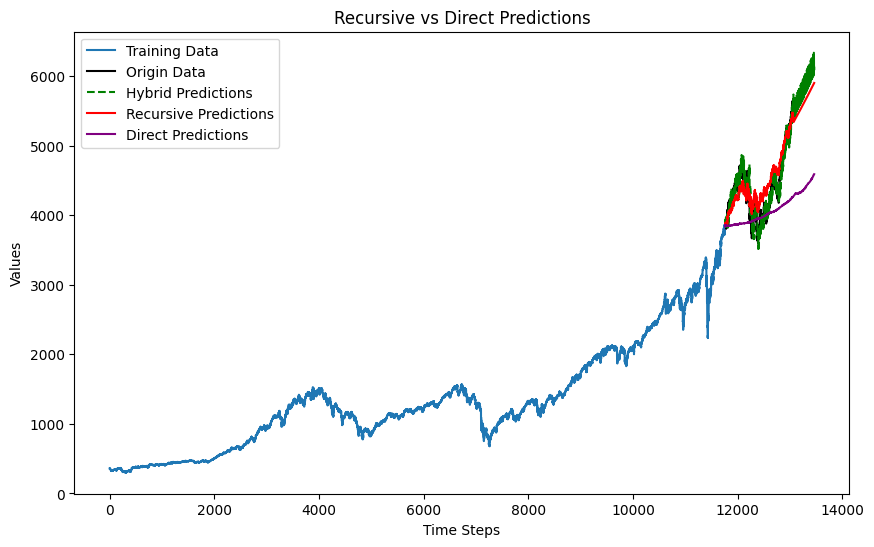

In [30]:
# scaler = StandardScaler()
# train_data = scaler.fit_transform(
#     X_train.reshape(-1, 1)).reshape(X_train.shape)

predict_and_forecast = PredictAndForecast(
    model, X_train, X_val,
    n_input=5, scaler=None,
    normalize_bool=False
)
step_time_prediction = 1700

predictions = predict_and_forecast.get_predictions(step=step_time_prediction)
print(f'Predictions shape: {predictions.shape}')
predictions = np.array(predictions).flatten()
# predict_and_forecast.plot_predictions(
#     steps=500, preds=predictions, normaliza_bool=True, scaler=scaler_type)
test_series, recursive_preds, direct_preds, hybrid_preds = predict_and_forecast.plot_predictions(
    steps=step_time_prediction, preds=predictions, normaliza_bool=True, scaler=scaler_type)

In [20]:
metrics = predict_and_forecast.evaluate_predictions(
    test_series, recursive_preds, direct_preds, hybrid_preds)
print(metrics)

Evaluation Metrics:

Recursive Predictions:
MAE: 277.10695281926803
MAPE: 0.05922322395143965
RMSE: 347.87206124312206
R2: 0.38374654625604687

Direct Predictions:
MAE: 347.1644344011914
MAPE: 0.07554524143146041
RMSE: 432.4251618980707
R2: 0.04776930101506227

Hybrid Predictions:
MAE: 116.4023963799303
MAPE: 0.026996516714397557
RMSE: 148.26920708058722
R2: 0.8880504904495459
{'recursive': {'MAE': 277.10695281926803, 'MAPE': 0.05922322395143965, 'RMSE': 347.87206124312206, 'R2': 0.38374654625604687}, 'direct': {'MAE': 347.1644344011914, 'MAPE': 0.07554524143146041, 'RMSE': 432.4251618980707, 'R2': 0.04776930101506227}, 'hybrid': {'MAE': 116.4023963799303, 'MAPE': 0.026996516714397557, 'RMSE': 148.26920708058722, 'R2': 0.8880504904495459}}


In [ ]:
predict_and_forecast.evaluate_predictions(
    steps=600, preds=predictions, normaliza_bool=True, scaler=scaler_type)

TypeError: PredictAndForecast.evaluate_predictions() got an unexpected keyword argument 'steps'

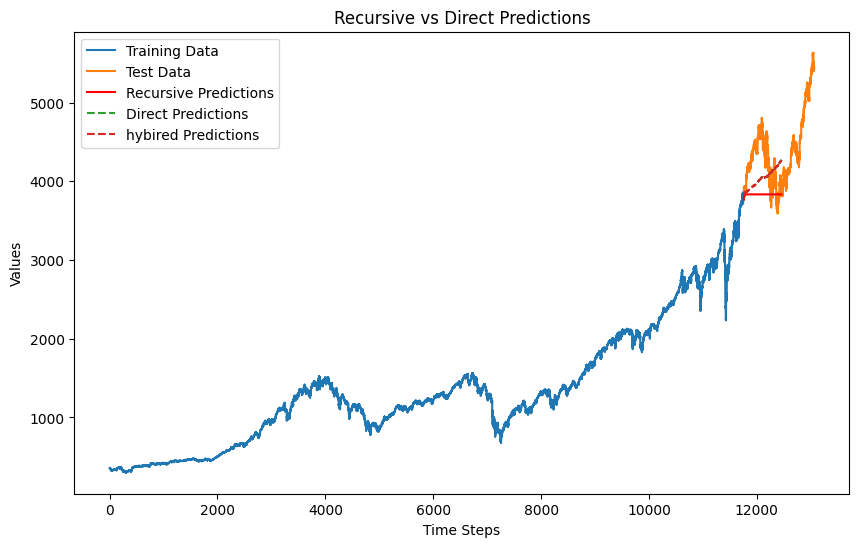

In [ ]:
predict_and_forecast.plot_predictions(steps=700, preds=predictions)

In [ ]:
predict_and_forecast.evaluate_predictions(steps=700)

Recursive MAE: 184.33419319718936
Recursive RMSE: 225.3724821301237
Recursive R2: -1.0961695730481695
Recursive MAPE: 0.037489060137923164
Direct MAE: 154.07138010071267
Direct RMSE: 192.74002184232185
Direct R2: -1.0961695730481695
Direct MAPE: 0.037489060137923164


In [ ]:
from tensorflow.keras import layers, models, optimizers, losses


def train_transformer(model, x_train, y_train, x_val, y_val, epochs=50, batch_size=32):
    optimizer = optimizers.Adam(learning_rate=1e-4)
    loss_fn = losses.MeanSquaredError()

    train_dataset = tf.data.Dataset.from_tensor_slices(
        (x_train, y_train)).batch(batch_size)
    val_dataset = tf.data.Dataset.from_tensor_slices(
        (x_val, y_val)).batch(batch_size)

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        # Training loop
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                predictions = model(x_batch_train, training=True)
                loss = loss_fn(y_batch_train, predictions)

            gradients = tape.gradient(loss, model.trainable_weights)
            optimizer.apply_gradients(zip(gradients, model.trainable_weights))

            if step % 100 == 0:
                print(f"Training loss at step {step}: {loss.numpy()}")

        # Validation loop
        val_loss = []
        for x_batch_val, y_batch_val in val_dataset:
            val_predictions = model(x_batch_val, training=False)
            val_loss.append(loss_fn(y_batch_val, val_predictions).numpy())

        print(f"Validation loss: {np.mean(val_loss)}")


def plot_results(train, test, preds, df, normalize_bool, scaler, title_suffix=None, xlabel='AAPL stock Price'):
    """
    Plots training data in blue, actual values in red, and predictions in green,
    over time.
    """

    fig, ax = plt.subplots(figsize=(20, 6))
    if not isinstance(df, pd.DataFrame):
        df = pd.DataFrame(df)
    # x = df.Close[-498:].index
    plot_test = test[1:]
    plot_preds = preds[1:]
    if normalize_bool == True:
        # Inverse transform to get back to original scale
        plot_test = scaler.inverse_transform(
            plot_test.reshape(-1, 1)).reshape(plot_test.shape)
        train = scaler.inverse_transform(
            train.reshape(-1, 1)).reshape(train.shape)
        plot_preds = scaler.inverse_transform(
            plot_preds.reshape(-1, 1)).reshape(plot_preds.shape)
        print("normalization convert active")

    # x = df[-(plot_test.shape[0]*plot_test.shape[1]):].index
    plot_test = plot_test.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
    plot_preds = plot_preds.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
    plot_train = train.reshape((train.shape[0]*train.shape[1], 1))
    print(f'plot_train shape: {plot_train.shape}')
    print(f'plot_test shape: {plot_test.shape}')
    print(f'plot_preds shape: {plot_preds.shape}')

    x_train = df[:len(plot_train)].index
    x_test = df[len(plot_train):len(plot_train) + len(plot_test)].index

    ax.plot(x_train, plot_train, label='Train', color='blue')
    ax.plot(x_test, plot_test, label='actual', color='red')
    ax.plot(x_test, plot_preds, label='preds', color='green')
    if title_suffix == None:
        ax.set_title('Predictions vs. Actual')
    else:
        ax.set_title(f'Predictions vs. Actual, {title_suffix}')
    ax.set_xlabel('Date')
    ax.set_ylabel(xlabel)
    ax.legend()
    plt.show()


train_transformer(model, X_train, y_train, X_val, y_val)

NameError: name 'model' is not defined